In [1]:
from typing import Callable, Tuple
from IPython.core.display_functions import display
from sklearn.datasets import make_classification, make_moons
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay, auc, roc_auc_score, f1_score, balanced_accuracy_score
from time import time_ns, time
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
plt.rcParams["figure.figsize"] = (20,10)
random_state = 244827
n_samples = 2427

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [3]:
def mse_cost(predicted, actual):
    return np.mean((predicted - actual) ** 2)

def logistic_cost(predicted, actual):
    return -np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))

In [4]:
class MyLogisticRegression:
    def __init__(self, learning_rate: float = 0.05, max_iter: int = 100, min_cost_diff: float = 1e-4,
                 cost_function: Callable = mse_cost):
        self.learning_rate = learning_rate
        self.max_iterations = max_iter
        self.min_cost_diff = min_cost_diff
        self.coef_ = None
        self.intercept_ = None
        self.cost_function = cost_function
        self.costs = []

    def fit(self, X, Y):
        if self.coef_ is None:
            self.coef_ = np.random.normal(loc=1, scale=.15, size=(1, X.shape[1]))
            self.intercept_ = np.random.normal(loc=1, scale=0.15, size=1)

        Y = Y.reshape(-1, 1)
        n = X.shape[0]
        for i in range(self.max_iterations):
            preds = sigmoid(X.dot(self.coef_.T) + self.intercept_)
            cost = self.cost_function(preds, Y)

            dW = 1/n * np.dot((preds - Y).T, X)
            dB = 1/n * np.sum(preds - Y)

            self.coef_ = self.coef_ - self.learning_rate * dW
            self.intercept_ = self.intercept_ - self.learning_rate * dB

            self.costs.append(cost)

            if len(self.costs) >= 2 and self.costs[-2] - self.costs[-1] < self.min_cost_diff:
                break

            if len(self.costs) >= 2 and self.costs[-1] > self.costs[-2]:
                self.learning_rate /= 2

        return self

    def decision_function(self, X):
        return sigmoid(X.dot(self.coef_.T) + self.intercept_)

    def predict(self, X):
        return np.where(self.decision_function(X) >= 0.5, 1, 0)

In [5]:
class PUMData:
    def __init__(self, gen, random_state=244827, test_size=0.2):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(gen[0], gen[1], test_size=test_size, random_state=random_state, shuffle=True, stratify=gen[1])

    def normalize(self, min_v=0, max_v=1):
        for i in range(self.x_train.shape[1]):
            x_min = np.min(self.x_train[:, i])
            x_max = np.max(self.x_train[:, i])
            if x_min != x_max:
                self.x_train[:, i] = (self.x_train[:, i] - x_min) / (x_max - x_min)
                self.x_train[:, i] = self.x_train[:, i] * (max_v - min_v) + min_v

                self.x_test[:, i] = (self.x_test[:, i] - x_min) / (x_max - x_min)
                self.x_test[:, i] = self.x_test[:, i] * (max_v - min_v) + min_v
            elif x_max == 0:
                self.x_train[:, i] = 0
                self.x_test[:, i] = 0
            else:
                self.x_train[:, i] = 1
                self.x_test[:, i] = 1


    def remove_outlisers(self):
        for i in range(self.x_train.shape[1]):
            if len(np.unique(self.x_train[:, i])) == 2:
                continue
            q1_train = np.percentile(self.x_train[:, i], 25)
            q3_train = np.percentile(self.x_train[:, i], 75)
            iqr_train = q3_train - q1_train
            self.x_train[:, i] = np.clip(self.x_train[:, i], q1_train - 1.5 * iqr_train, q3_train + 1.5 * iqr_train)

            q1_test = np.percentile(self.x_test[:, i], 25)
            q3_test = np.percentile(self.x_test[:, i], 75)
            iqr_test = q3_test - q1_test
            self.x_test[:, i] = np.clip(self.x_test[:, i], q1_test - 1.5 * iqr_test, q3_test + 1.5 * iqr_test)

    def make_polynomial(self, poly_degree=2, include_bias=False):
        self.x_test = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_test)
        self.x_train = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_train)

In [6]:
def compare_models(data: PUMData, poly_degree=1, use_bias=False, verbose=3):
    my_start = time_ns()
    my_model = MyLogisticRegression(learning_rate=0.01, max_iter=100, min_cost_diff=1e-4, cost_function=logistic_cost)
    for _ in range(100):
        my_model = MyLogisticRegression(learning_rate=1, max_iter=1000, min_cost_diff=1e-4, cost_function=logistic_cost)
        my_model.fit(data.x_train, data.y_train)
    my_time = time_ns() - my_start

    sk_model = LogisticRegression(solver='liblinear', max_iter=100, random_state=random_state)
    sk_start = time_ns()
    for _ in range(100):
        sk_model = LogisticRegression(solver='liblinear', max_iter=100, random_state=random_state)
        sk_model.fit(data.x_train, data.y_train)
    sk_time = time_ns() - sk_start

    print(f'Implementacja wlasna \tuczyla sie przez {my_time/100} ns')
    print(f'Model sklearn \t\t\t uczyl sie przez {sk_time/100} ns')

    # if verbose >= 3 and data.x_train.shape[1] == 2:
    x_min, x_max = data.x_test[:, 0].min() - 0.25, data.x_test[:, 0].max() + 0.25
    y_min, y_max = data.x_test[:, 1].min() - 0.25, data.x_test[:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh_data = np.c_[xx.ravel(), yy.ravel()]

    if poly_degree > 1:
        mesh_data = PolynomialFeatures(degree=poly_degree, include_bias=use_bias).fit_transform(mesh_data)

    Z_an = my_model.predict(mesh_data).reshape(xx.shape)
    Z_sk = sk_model.predict(mesh_data).reshape(xx.shape)

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(20, 15))

    for idx, Z, title in zip(
        range(2),
        [Z_an, Z_sk],
        ['Implementacja własna', 'Model LogisticRegression']):
        axarr[idx].contourf(xx, yy, Z, alpha=0.4, levels=1)
        axarr[idx].scatter(data.x_test[:, 0], data.x_test[:, 1], c=data.y_test, s=20, edgecolor="k")
        axarr[idx].set_title(title)

    plt.show()

    y_an_predicted = my_model.predict(data.x_test)
    y_sk_predicted = sk_model.predict(data.x_test)

    cm_sk = confusion_matrix(data.y_test, y_sk_predicted)
    cm_an = confusion_matrix(data.y_test, y_an_predicted)

    sensitivity_sk = cm_sk[1, 1] / (cm_sk[1, 0] + cm_sk[1, 1])
    specifity_sk = cm_sk[0, 0] / (cm_sk[0, 0] + cm_sk[0, 1])

    sensitivity_an = cm_an[1, 1] / (cm_an[1, 0] + cm_an[1, 1])
    specifity_an = cm_an[0, 0] / (cm_an[0, 0] + cm_an[0, 1])

    if verbose >= 1:
        print(f'Model własny: Czulość: {sensitivity_an}, swoistość: {specifity_an}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_an_predicted, adjusted=True)}')
        print(f'Model sklearn: Czulość: {sensitivity_sk}, swoistość: {specifity_sk}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_sk_predicted, adjusted=True)}')

    # if verbose >= 0.5:
    #     print(f'Model własny:  Adjusted accuracy={balanced_accuracy_score(data.y_test, y_an_predicted, adjusted=True)}')
    #     print(f'Model sklearn: Adjusted accuracy={balanced_accuracy_score(data.y_test, y_sk_predicted, adjusted=True)}')

    if verbose >= 2:
        f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(15, 8))

        for idx, cm, title in zip(
            range(2),
            [cm_an, cm_sk],
            ['Implementacja własna', 'Model LogisticRegression']
        ):
            sns.heatmap(cm, annot=True, fmt="d", ax=axarr[idx], cmap="Blues")
            axarr[idx].set_title(title)

        plt.show()

        my_function = my_model.decision_function(data.x_test)
        sk_function = sk_model.decision_function(data.x_test)

        fpr, tpr, thresholds = roc_curve(data.y_test, my_function)
        plt.plot(fpr, tpr, label=f'my model, AUC={roc_auc_score(data.y_test, my_function):.3f}')
        fpr, tpr, thresholds = roc_curve(data.y_test, sk_function)
        plt.plot(fpr, tpr, label=f'sklearn model, AUC={roc_auc_score(data.y_test, sk_function):.3f}')
        plt.legend()
        plt.show()

Implementacja wlasna 	uczyla sie przez 3883555.0 ns
Model sklearn 			 uczyl sie przez 1096370.0 ns


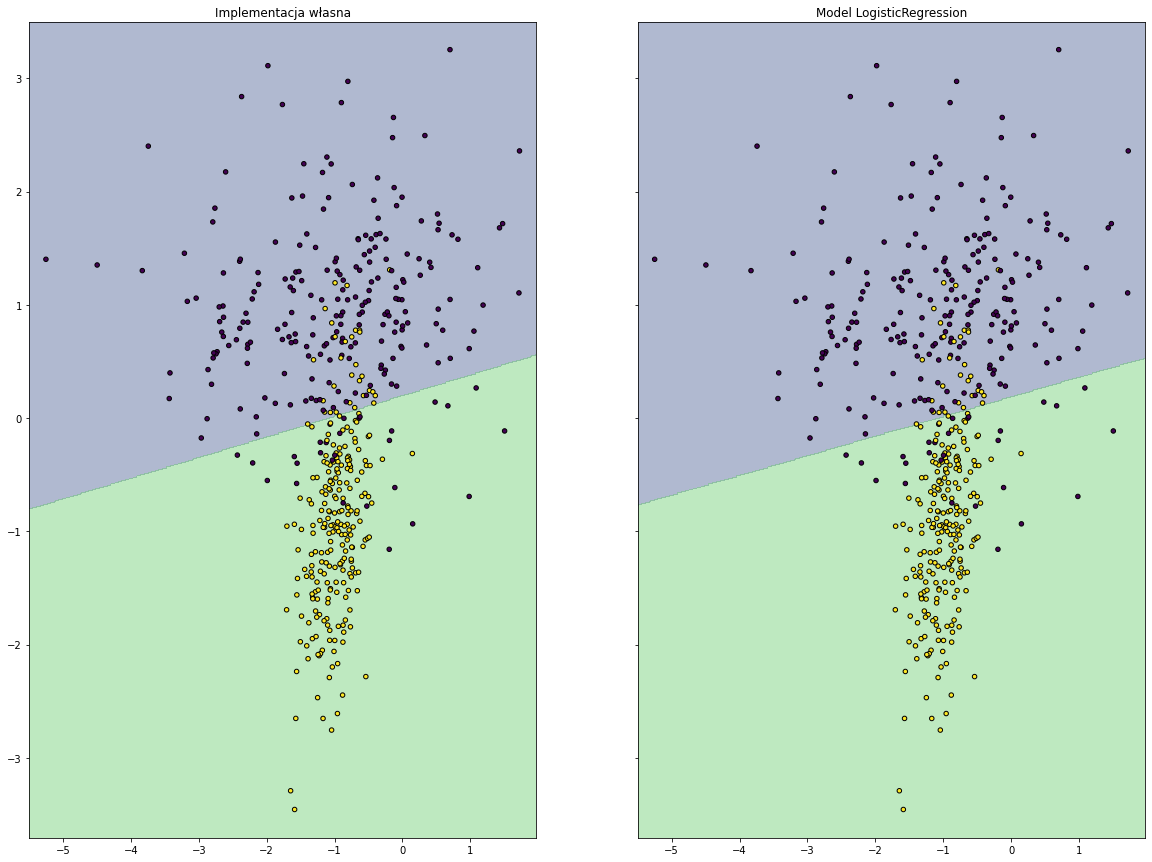

Model własny: Czulość: 0.8770491803278688, swoistość: 0.8842975206611571, Adjusted accuracy=0.761346700989026
Model sklearn: Czulość: 0.8770491803278688, swoistość: 0.8842975206611571, Adjusted accuracy=0.761346700989026


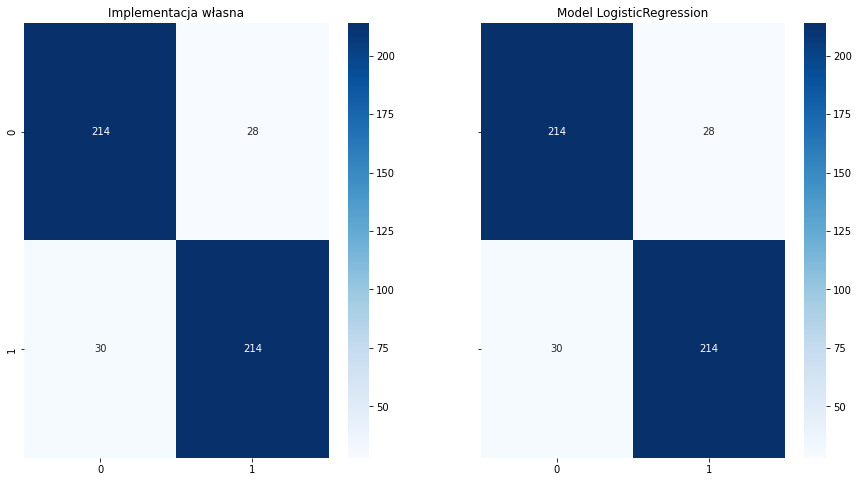

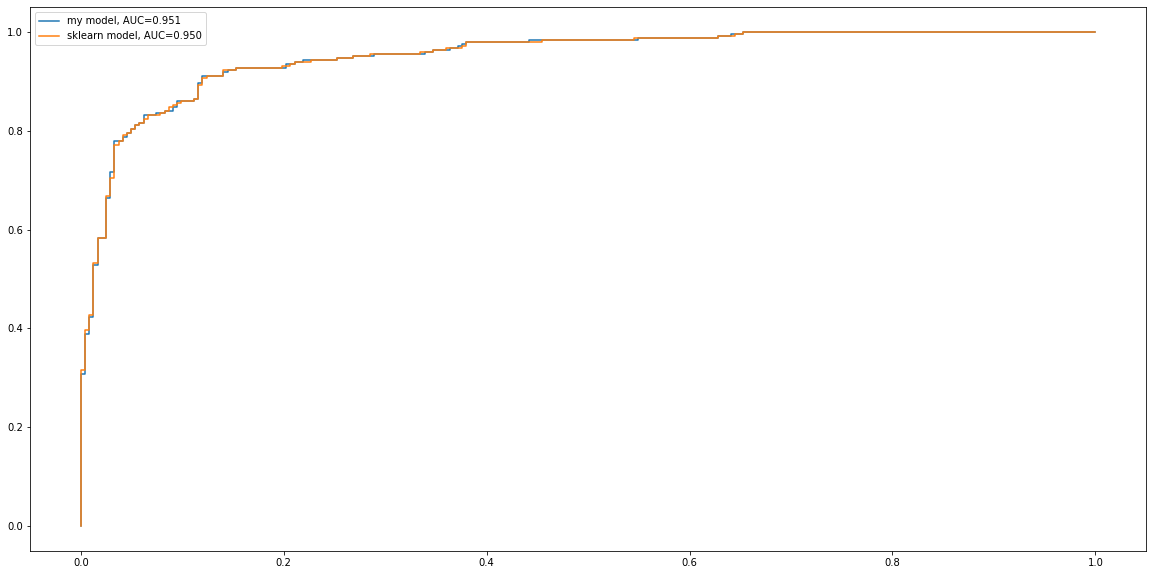

In [7]:
data_classification = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=random_state), random_state=random_state)
# data_classification.normalize()
compare_models(data_classification)

Implementacja wlasna 	uczyla sie przez 73165492.0 ns
Model sklearn 			 uczyl sie przez 2197410.0 ns


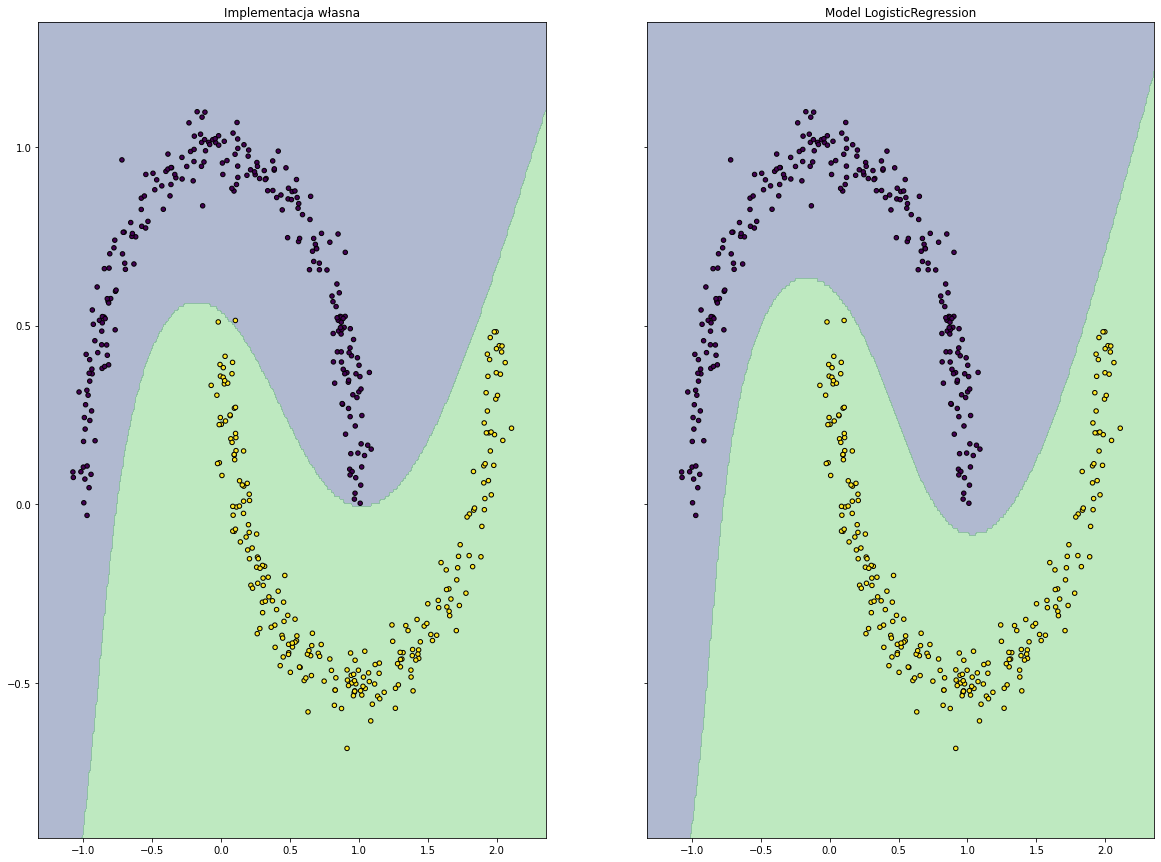

Model własny: Czulość: 0.9958847736625515, swoistość: 1.0, Adjusted accuracy=0.9958847736625516
Model sklearn: Czulość: 1.0, swoistość: 1.0, Adjusted accuracy=1.0


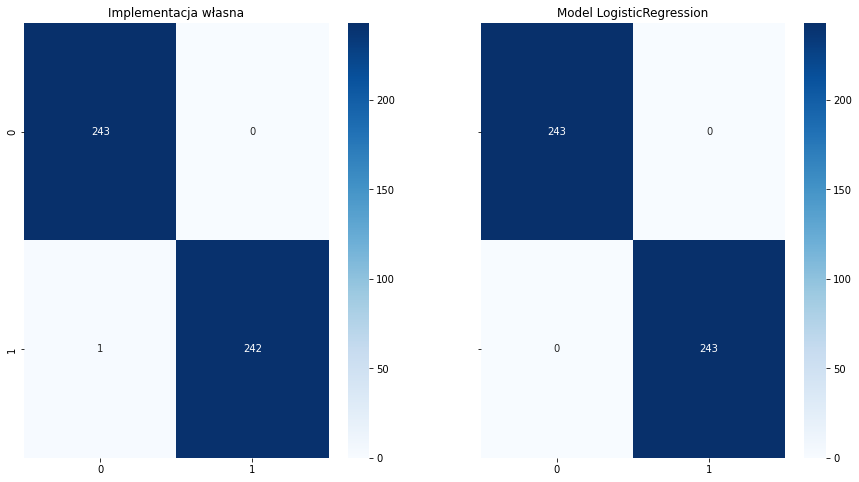

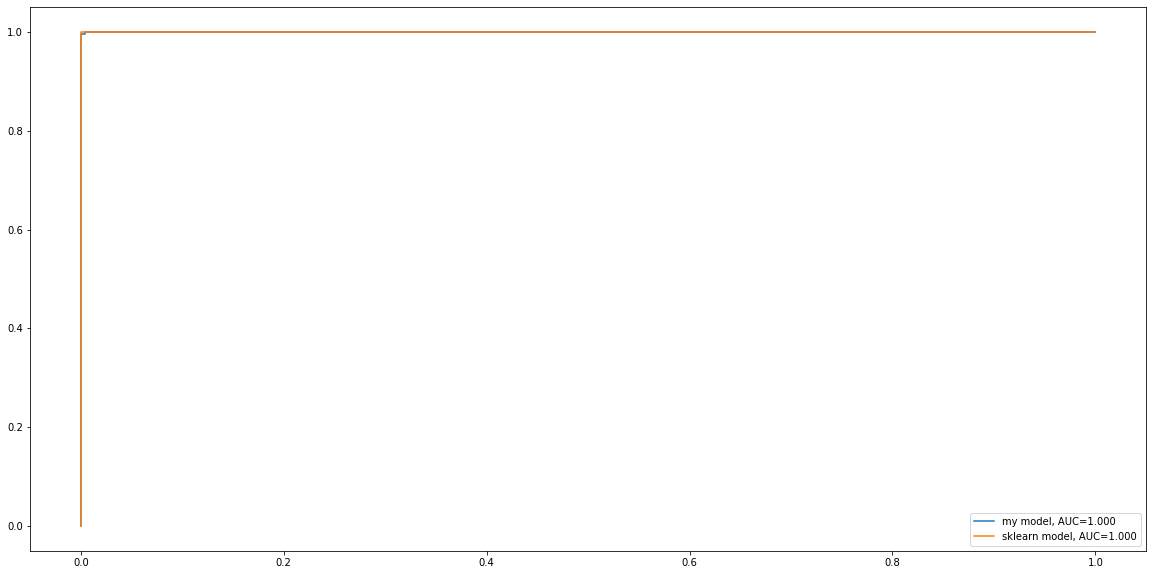

In [8]:
data_moons = PUMData(make_moons(n_samples=n_samples, noise=0.05, random_state=random_state))
# data_moons.normalize()
data_moons.make_polynomial(poly_degree=3)
compare_models(data_moons, poly_degree=3, use_bias=False)

Implementacja włąsna uczyła się o cały rząd wielkości dłużej niż sklearn aby osiągnąć ten sam efekt.

## Część 2.

Wczytanie danych, usunięcie kolumn z brakami przekraczającym 30% oraz podgląd danych na jakich pracujemy

In [9]:
rainDF = pd.read_csv('rainAUS.csv', delimiter=',')
rainDF = rainDF.dropna(subset=['RainTomorrow'])
rainDF = rainDF.loc[:, rainDF.isin(['NaN', np.NaN]).mean() < .3]
rainDF = rainDF.reset_index(drop=True)
rainDF.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


Imputacja pozostałych brakujących danych oraz zakodowanie kolumny RainToday

In [10]:
temp = rainDF.median(axis=0, numeric_only=True)

for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']:
    rainDF[col].fillna(rainDF[col].mode()[0], inplace=True)

for index, value in temp.items():
    rainDF[index].fillna(value, inplace=True)

rainDF['RainToday'] = rainDF['RainToday'].replace(['Yes', 'No'], [1, 0])
rainDF['RainTomorrow'] = rainDF['RainTomorrow'].replace(['Yes', 'No'], [1, 0])

Kodowanie danych kategorychnych systemem one-hot

In [11]:
encoder = OneHotEncoder()
encoded = pd.DataFrame(encoder.fit_transform(rainDF[['WindGustDir', 'WindDir9am', 'WindDir3pm']]).toarray())
rainDF = rainDF.join(encoded)

rainDF.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1, inplace=True)

Przerobienie daty na 3 osobne kolumny

In [12]:
rainDF['Date'] = pd.to_datetime(rainDF['Date'])
rainDF['Day'] = rainDF['Date'].dt.day
rainDF['Month'] = rainDF['Date'].dt.month
rainDF['Year'] = rainDF['Date'].dt.year
rainDF.drop(['Date'], axis=1, inplace=True)
# rainDF = rainDF.apply(pd.to_numeric, errors='coerce')

In [13]:
rainDF.head(5)

,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,41,42,43,44,45,46,47,Day,Month,Year
0,Albury,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,12,2008
1,Albury,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,12,2008
2,Albury,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,12,2008
3,Albury,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,12,2008
4,Albury,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,12,2008


Podział danych na podzbiory dla poszczególnych lokacji

In [14]:
rain_data_split = {}
for location in rainDF['Location'].unique():
    labels = rainDF[rainDF['Location'] == location]['RainTomorrow'].copy().to_numpy()
    data = rainDF[rainDF['Location'] == location].drop(['Location', 'RainTomorrow'], axis=1).copy()
    data = data.to_numpy().astype(np.float64)
    rain_data_split[location] = PUMData((data, labels))
    rain_data_split[location].remove_outlisers()
    rain_data_split[location].normalize()


In [15]:
def fit_to_locations(locations_data: dict) -> Tuple[dict, dict]:
    models = {}
    scores = {}
    for location in locations_data.keys():
        # print(location)
        models[location] = (MyLogisticRegression(learning_rate=1, max_iter=10000, cost_function=logistic_cost), LogisticRegression(solver='liblinear', max_iter=100))

        models[location][0].fit(locations_data[location].x_train, locations_data[location].y_train)
        models[location][1].fit(locations_data[location].x_train, locations_data[location].y_train)

        y_an_predicted = models[location][0].predict(locations_data[location].x_test)
        y_sk_predicted = models[location][1].predict(locations_data[location].x_test)

        scores[location] = (np.abs(balanced_accuracy_score(locations_data[location].y_test, y_an_predicted, adjusted=True)), np.abs(balanced_accuracy_score(locations_data[location].y_test, y_sk_predicted, adjusted=True)))
    return models, scores


def plot_scores(scores):
    plt.bar([i*2 for i in range(len(scores.keys()))], [score[0] for score in scores.values()], label='Mój model', align='edge')
    plt.bar([i*2+1 for i in range(len(scores.keys()))], [score[1] for score in scores.values()], label='sklearn model', align='edge')
    plt.legend()
    plt.xticks([i*2+1 for i in range(len(scores.keys()))], [location for location in scores.keys()], rotation = 90)
    plt.show()


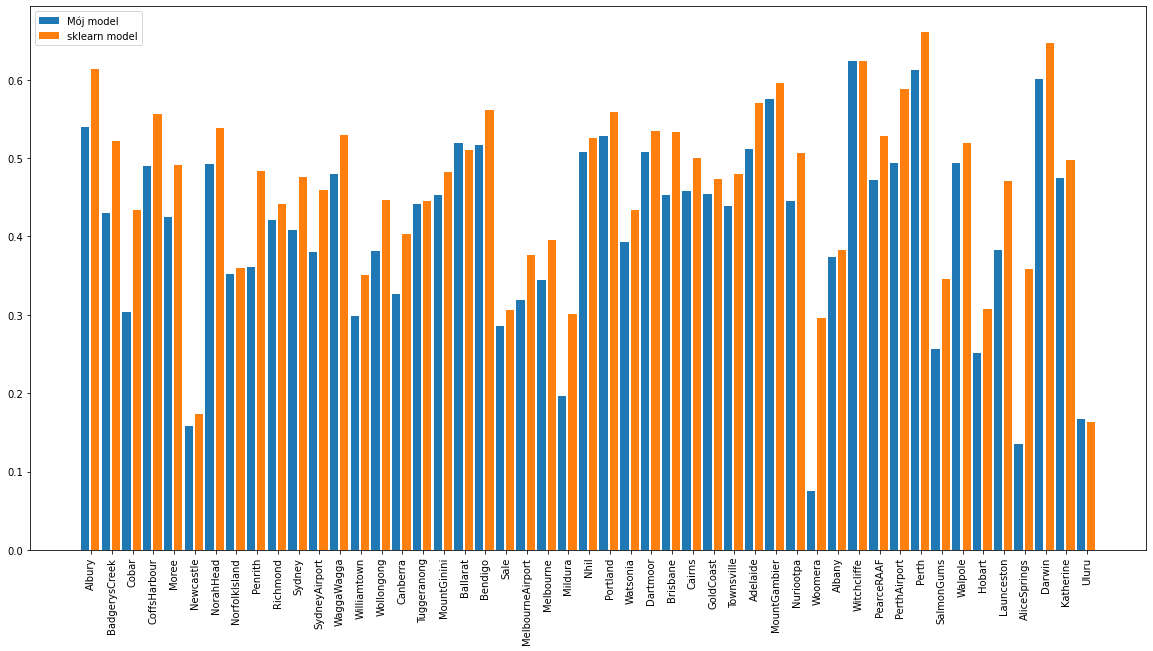

Trening uczenia na pełnych danych: 3.4521634578704834s


In [16]:
full_start = time()
models, scores = fit_to_locations(rain_data_split)
plot_scores(scores)
full_time = time() - full_start
print(f'Trening uczenia na pełnych danych: {full_time}s')

Najlepszy wynik sklearn uzyskał dla lokacji Perth, natomiast implementacja własna uzyskała najlepszy wynik dla lokacji Portland.

In [17]:
print(f'Dla lokacji Perth model sklearn uzyskał balanced adjusted accuracy: {scores["Perth"][1]}, implementacja własna uzyskała balanced adjusted accuracy: {scores["Perth"][0]}')

Dla lokacji Perth model sklearn uzyskał balanced adjusted accuracy: 0.6605107159142727, implementacja własna uzyskała balanced adjusted accuracy: 0.6121295029639762


In [18]:
rainDF_s = pd.read_csv('rainAUS.csv', delimiter=',')
rainDF_s = rainDF_s.dropna(subset=['RainTomorrow'])
rainDF_s = rainDF_s.loc[:, rainDF_s.isin(['NaN', np.NaN]).mean() < .3]
rainDF_s = rainDF_s.reset_index(drop=True)
temp = rainDF_s.median(axis=0, numeric_only=True)

for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']:
    rainDF_s[col].fillna(rainDF_s[col].mode()[0], inplace=True)

for index, value in temp.items():
    rainDF_s[index].fillna(value, inplace=True)

rainDF_s['RainToday'] = rainDF_s['RainToday'].replace(['Yes', 'No'], [1, 0])
rainDF_s['RainTomorrow'] = rainDF_s['RainTomorrow'].replace(['Yes', 'No'], [1, 0])
rainDF_s.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1, inplace=True)

rainDF_s['Date'] = pd.to_datetime(rainDF_s['Date'])
rainDF_s['Day'] = rainDF_s['Date'].dt.day
rainDF_s['Month'] = rainDF_s['Date'].dt.month
rainDF_s['Year'] = rainDF_s['Date'].dt.year
rainDF_s.drop(['Date'], axis=1, inplace=True)

rain_data_filtered_split = {}
for location in rainDF_s['Location'].unique():
    labels = rainDF_s[rainDF_s['Location'] == location]['RainTomorrow'].copy().to_numpy()
    data = rainDF_s[rainDF_s['Location'] == location].drop(['Location', 'RainTomorrow'], axis=1).copy()
    data = data.to_numpy().astype(np.float64)
    rain_data_filtered_split[location] = PUMData((data, labels))
    rain_data_filtered_split[location].remove_outlisers()
    rain_data_filtered_split[location].normalize()

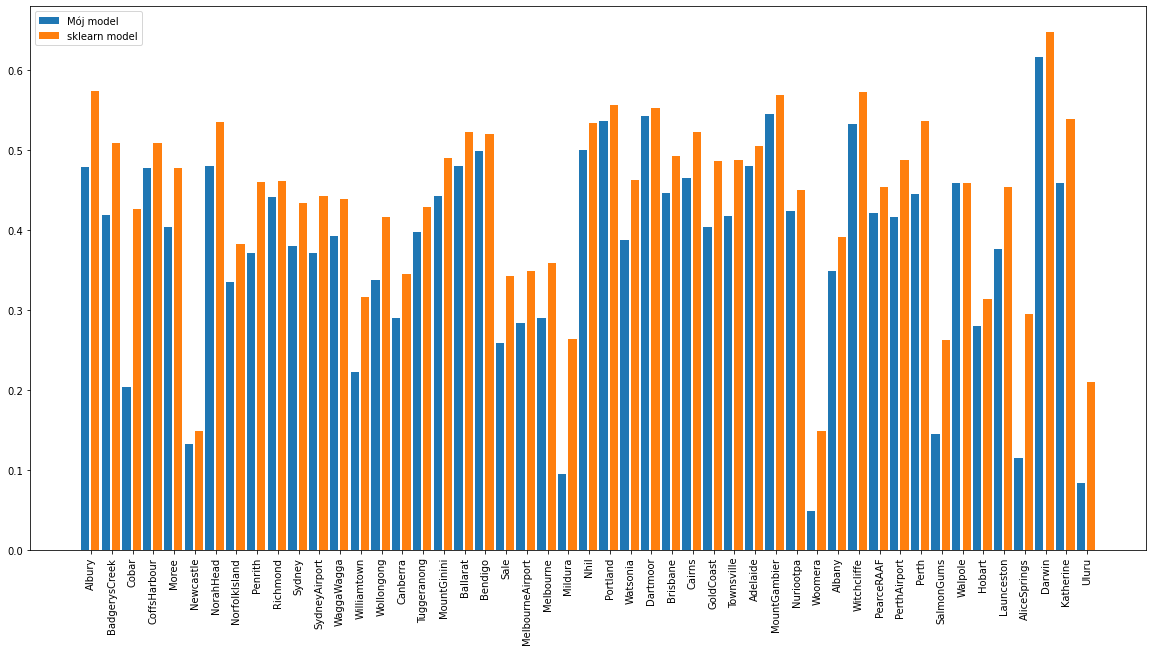

Trening uczenia na danych bez kolumn z informacjami o kierunku wiatru: 2.640279769897461s


In [19]:
train_s_start = time()
models_s, scores_s = fit_to_locations(rain_data_filtered_split)
plot_scores(scores_s)
train_s_time = time() - train_s_start
print(f'Trening uczenia na danych bez kolumn z informacjami o kierunku wiatru: {train_s_time}s')

## Część 3.

In [20]:
labels = rainDF['RainTomorrow'].copy().to_numpy()
data = rainDF.drop(['Location', 'RainTomorrow'], axis=1).copy()
data = data.to_numpy().astype(np.float64)
country_data = PUMData((data, labels))
country_data.remove_outlisers()
country_data.normalize()

In [21]:
def compare_country_on_locations(count_data, trained_models):
    temp_scores = {}
    for location, model in trained_models.items():
        my_model = model[0]
        sk_model = model[1]
        y_an_predicted = my_model.predict(count_data.x_test)
        y_sk_predicted = sk_model.predict(count_data.x_test)

        an_cm = confusion_matrix(count_data.y_test, y_an_predicted)
        sk_cm = confusion_matrix(count_data.y_test, y_sk_predicted)

        an_sensitivity = an_cm[1, 1] / (an_cm[1, 1] + an_cm[1, 0])
        sk_sensitivity = sk_cm[1, 1] / (sk_cm[1, 1] + sk_cm[1, 0])

        an_specificity = an_cm[0, 0] / (an_cm[0, 0] + an_cm[0, 1])
        sk_specificity = sk_cm[0, 0] / (sk_cm[0, 0] + sk_cm[0, 1])

        temp_scores[location] = (an_sensitivity + an_specificity - 1, sk_sensitivity + sk_specificity - 1)

    plt.bar([i * 2 for i in range(len(trained_models.keys()))], [score[0] for score in temp_scores.values()], label='Mój model', align='edge')
    plt.bar([i * 2 + 1 for i in range(len(trained_models.keys()))], [score[1] for score in temp_scores.values()], label='sklearn model', align='edge')
    plt.legend()
    plt.xticks([i * 2 + 1 for i in range(len(trained_models.keys()))], [location for location in trained_models.keys()], rotation = 90)
    plt.show()

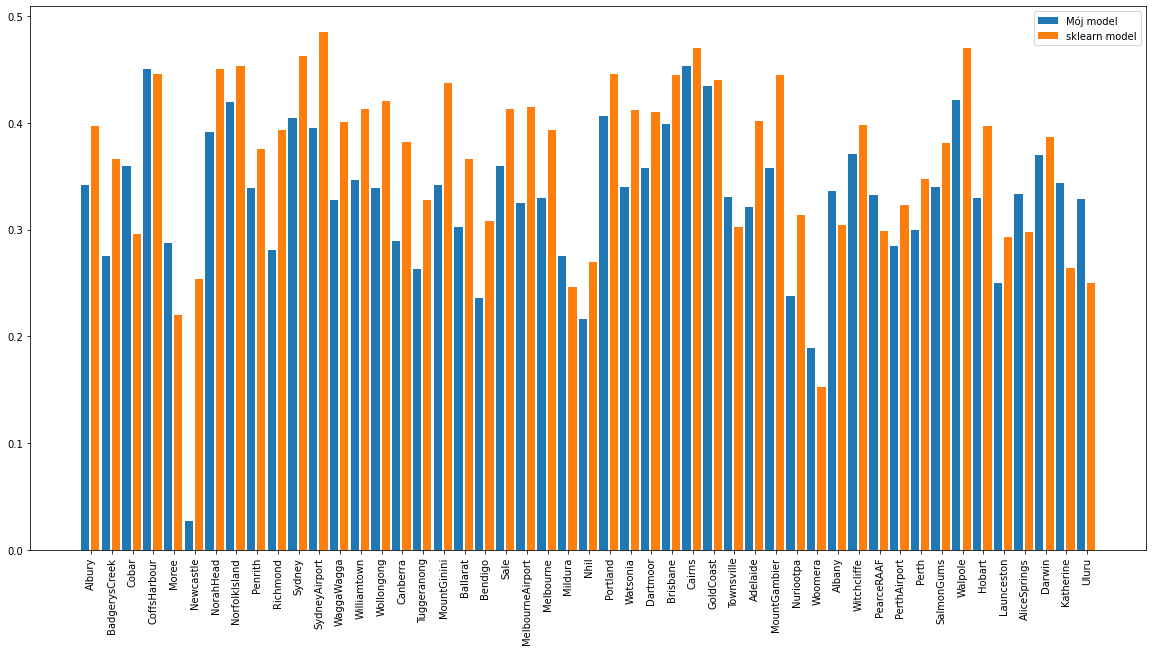

In [22]:
compare_country_on_locations(country_data, models)

In [23]:
dummy_model = DummyClassifier()
dummy_model.fit(country_data.x_train, country_data.y_train)
best_my_model = models['Darwin'][0]
best_sk_model = models['Perth'][1]

In [24]:
dummy_preds = dummy_model.predict(country_data.x_test)

In [25]:
print(f'dummy_model bal adj acc = {balanced_accuracy_score(country_data.y_test, dummy_preds, adjusted=True)}')
print(f'My model bal adj acc = {balanced_accuracy_score(country_data.y_test, best_my_model.predict(country_data.x_test), adjusted=True)}')
print(f'sklearn model bal adj acc = {balanced_accuracy_score(country_data.y_test, best_sk_model.predict(country_data.x_test), adjusted=True)}')

dummy_model bal adj acc = 0.0
My model bal adj acc = 0.3701804874233958
sklearn model bal adj acc = 0.34766645338338376
